### Step 1: Importing Necessary Libraries
In this step, we import all necessary libraries and modules required for our facial recognition task. This includes libraries for data handling (`numpy`, `os`), image processing (`matplotlib.pyplot`), and deep learning (`tensorflow`). The `sklearn.model_selection` module provides tools for splitting the dataset into training, validation, and testing sets. These libraries provide the foundational tools needed to preprocess the data, construct and train the deep learning model, and evaluate its performance.

In [3]:
!pip install keras

In [4]:
# Import libraries for data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import os

# Import TensorFlow and Keras for model building and training
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


### Step 2: Data Upload and Import
Here, we define the path to our dataset and load the images. The ORL Database of Faces is structured such that each subject has a separate folder containing their images. We loop through these folders, read each image, and store them in a structured numpy array. This array, `dataset_faces`, will contain all the facial images organized in a way that makes them easy to access and manipulate for training purposes. The dimensions of `dataset_faces` reflect the number of subjects, the number of images per subject, and the image sizes.

In [12]:
# Define the path to the dataset
dataset_path = '/Users/toddwalters/Development/data/advDLandCV/projects/1697032566/att_faces'  # Update this path to your dataset location

# Load the dataset into a structured numpy array
dataset_faces = []
for person in range(1, 41):
    temp = []
    for pose in range(1, 11):
        # image_path = f'{dataset_path}/s{person}/{pose}.pgm'
        image_path = f'{dataset_path}/s{person}/{pose}.png'
        image = plt.imread(image_path)
        temp.append(image)
    dataset_faces.append(np.array(temp))
dataset_faces = np.array(dataset_faces)

# Print the dataset information
print('Total number of datasets:', len(dataset_faces))
print('Dataset size:', dataset_faces.shape)

Total number of datasets: 40
Dataset size: (40, 10, 112, 92)


### Step 3: View a Few Images
Visualizing the data is a crucial step to understand its characteristics and confirm that it has been loaded correctly. In this step, we define a function `plot_images` to display a selection of images from the dataset. This helps us to visually inspect the images for quality, variations, and any anomalies. For demonstration, we plot images from the first subject.

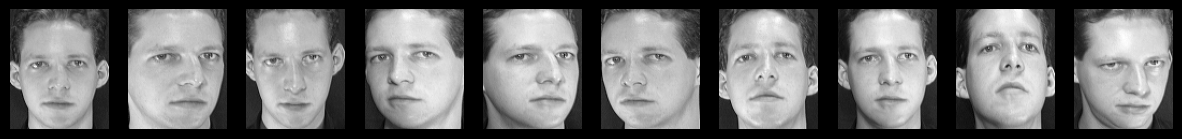

In [13]:
# Function to plot images
def plot_images(images, n=10):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Plot images from the first subject to get a sense of the data
plot_images(dataset_faces[0])


### Step 4: Create Validation Framework and Split Data
To train our model effectively, we need to split our dataset into training, testing, and validation sets. This process involves reshaping our data to fit the model's input requirements and splitting it in a manner that ensures a representative distribution of data across each set. The validation set is used to tune the model's hyperparameters without using the test data, providing an unbiased evaluation of the model's performance during training.


In [14]:
dataset_faces.shape

(40, 10, 112, 92)

In [15]:
# Flatten the dataset and create labels
num_subjects, num_images_per_subject, height, width = dataset_faces.shape
X = dataset_faces.reshape(num_subjects * num_images_per_subject, height, width, 1)  # Adding channel dimension
y = np.repeat(np.arange(num_subjects), num_images_per_subject)

# Split the dataset into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


### Step 5: Prepare the Data for CNN Model
Before feeding the data into our Convolutional Neural Network (CNN), we need to perform some preprocessing. This includes normalizing the pixel values of the images to a range of 0 to 1 to help the learning process converge more quickly. We also convert the labels into a one-hot encoded format, which is required for classification tasks in Keras. This step ensures our data is in the correct format for training.


In [16]:
# Normalize pixel values for model input
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_subjects)
y_test = to_categorical(y_test, num_subjects)
y_val = to_categorical(y_val, num_subjects)


### Step 6: Build the CNN Model
Here, we define the architecture of our CNN model. The model consists of convolutional layers for feature extraction, max pooling layers to reduce the dimensionality, and a dense layer for classification. The dropout layer is included to prevent overfitting by randomly dropping units from the neural network during training. The model is compiled with the Adam optimizer and categorical crossentropy loss function, which are suitable for multi-class classification tasks.


In [17]:
# Define the CNN model architecture
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(height, width, 1)),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_subjects, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


/opt/homebrew/anaconda3/envs/capstone/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Step 7: Train the Model
In this step, we train the model using our prepared training data. We also use the validation set to monitor the model's performance on unseen data. This allows us to adjust the model's parameters as needed to improve performance. The training process involves finding the best weights for the model's layers to minimize the loss function, thereby increasing the accuracy of the model on predicting the correct labels for the images.


In [18]:
# Train the model with the training data and validate using the validation set
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step - accuracy: 0.0505 - loss: 3.6889 - val_accuracy: 0.0125 - val_loss: 3.6892
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 516ms/step - accuracy: 0.0261 - loss: 3.6886 - val_accuracy: 0.0250 - val_loss: 3.6897
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 519ms/step - accuracy: 0.0298 - loss: 3.6882 - val_accuracy: 0.0250 - val_loss: 3.6907
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 510ms/step - accuracy: 0.0188 - loss: 3.6878 - val_accuracy: 0.0125 - val_loss: 3.6922
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 512ms/step - accuracy: 0.0394 - loss: 3.6862 - val_accuracy: 0.0375 - val_loss: 3.6947
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 513ms/step - accuracy: 0.0215 - loss: 3.6860 - val_accuracy: 0.0000e+00 - val_loss: 3.6987
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 508ms/step - accuracy: 0.0273 - loss: 3.6834 - val_accuracy: 0.0000e+00 - val_loss: 3.7041
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step - accuracy: 0.0148 - loss: 3.6806 - val_accuracy: 0.

### Step 8: Plot the Results
After training the model, we plot the training and validation accuracy and loss over the epochs. These plots are crucial for understanding the learning process of the model. They help in identifying issues such as overfitting, underfitting, or whether the model has sufficiently learned from the training data. Adjustments to the model architecture or training process may be necessary based on these insights.

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()
